In [1214]:
import numpy as np
import matplotlib
import time
#from termcolor import colored
from scipy.integrate import solve_ivp
from scipy.linalg import norm
from numpy import pi as pi
import scipy
from scipy import sparse
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from numpy.random import choice, normal
from numpy import concatenate
from scipy.sparse import coo_matrix
from scipy.sparse import kron
import pandas as pd
from mpl_toolkits import mplot3d
from numba import jit
from scipy.linalg import expm
import numbers
from numpy import imag, conj, cos, sin
from numpy import sqrt, zeros, diag, random, real, array, complex_, transpose, conjugate, exp, matmul, real, dot, add, sum
import pandas as pd



df=pd.read_csv('Atom_positions__MACE_2_level_2000_atoms_Lax_10_3D_gas_fixed_size_k_along_x_eL_along_z_rabi_0,1.txt') 


t0=time.time()


Gamma_r=1    #  2*pi*6e6  #reference
Omega=2*Gamma_r   #Gamma_r  #Driving frequency , What are the units?

N_atom=200      #Number of atoms
lambda_r  =1    # in units
Lambda_las=1     # in units    Gamma_r*2*pi/(wL/c_light)   #Laser wavelenght  , What are the units?
e_L=array([0,0,1]/sqrt(1))

Theta1=pi/2
Theta2=pi/2   #they got [0,1,0]

e_0=array([0,0,1]/sqrt(1))   #array([sin(Theta1)*cos(Theta2),sin(Theta1)*sin(Theta2),cos(Theta1)])

K_laser=(2*pi/Lambda_las)*array([1,0,0])
k0=2*pi/Lambda_las
Gamma_dec=Gamma_r

# Clebsch-Gordan coefficient

# Clebsch-Gordan coefficient
C00=1    

# Positions


## Oblate Variances matrix: Set the shape of the atoms cloud

Sigma_x=20 *lambda_r/2    
Sigma_y=0.2*lambda_r/2 
Sigma_z=Sigma_y     /2


Oblate_variances=zeros((3,3))

Oblate_variances[0][0]=Sigma_x**2
Oblate_variances[1][1]=Sigma_y**2
Oblate_variances[2][2]=Sigma_z**2

Miu_pos=[0 , 0, 0]

Pos_atoms=(random.multivariate_normal(Miu_pos, Oblate_variances, N_atom))


Pos_atoms=Pos_atoms[Pos_atoms[:,0].argsort()]


for j in range(N_atom):
    Pos_atoms[j]=np.array([0.1*Lambda_las*j,0,0])
  
# 2*np.pi

#Pos_atoms
#Pos_atoms    



# Construct $I_{Lk}$ and $R_{Lk}$
#Pos_atoms=array(df)


# Construct I_Lk and R_Lk

eL_e0c=dot(e_L,conj(e_0))

conj_0=conj(e_0)

DotKL_rk=[]   #summarize k_L.r_k for all k

for j in range(N_atom):
    DotKL_rk.append(dot(Pos_atoms[j],K_laser))

DotKL_rk_exp=exp(1j*array(DotKL_rk))


ZL_k= DotKL_rk_exp*eL_e0c


ImL_k=imag(ZL_k)
RmL_k=real(ZL_k)


# Construct $G_{ij}$

# Construct the matrix R00
#t0=time.time()

@jit
def fun_Pkl0(k,l,k0=k0):
    
    VecR_kl=Pos_atoms[k]-Pos_atoms[l]
    R_kl=sqrt(dot(VecR_kl,VecR_kl))
    #R_kl=norm(VecR_kl)
    
    
    #Pkl0=dot(conj(e_0),VecR_kl)
    Pkl0=dot(conj_0,VecR_kl)/R_kl
    Pkl_0nC=(abs(Pkl0))**2
    
    M0kl=k0*R_kl
    
    return (1-Pkl_0nC)/M0kl+(1-3*Pkl_0nC)*(1j/(M0kl)**2-1/(M0kl)**3)
    


MatL=zeros((N_atom,N_atom),dtype='complex64')
MatR=zeros((N_atom,N_atom),dtype='complex64')


for i in range(N_atom):
    for j in range(i+1,N_atom):

        VecR_ij=Pos_atoms[i] -Pos_atoms[j]

        MatL[i][j]=exp(1j*k0*sqrt(dot(VecR_ij,VecR_ij)))
        MatR[i][j]=fun_Pkl0(i,j,k0)

                
MatR=MatR+MatR.T
MatL=MatL+(MatL.T)


Gij=(3*Gamma_dec/4)*MatL*MatR


#t1=time.time()

Gij=Gij + 1j*0.5*Gamma_r*np.identity(N_atom) 

Abs_Gij=abs(Gij)

ReG=real(Gij)
ImG=imag(Gij)

#tspan=np.linspace(0,7,250)
Collect    =0



#t0=time.time()

In [1215]:
from numpy import dot


In [1216]:
Atom_cutoff=2

In [1217]:
N_atom

200

In [1218]:
Sigma_eg=csr_matrix(np.array([[0,1],
                              [0,0]]),dtype="complex64")
Id_2LS  =csr_matrix(np.array([[1,0],
                              [0,1]]),dtype="complex64")

Zero_2LS=csr_matrix(np.array([[0,0],
                              [0,0]]),dtype="complex64")

state   =csr_matrix(np.array([[0,0],
                              [0,1]]),dtype="complex64")


Sigma_ee=csr_matrix(np.array([[1,0],
                              [0,0]]),dtype="complex64")

Sigma_egT=Sigma_eg.T    


In [1219]:
def index_Gij(arr,Atom_cutoff):
    
    Ordered_N = list(np.argsort(arr)[::-1][:Atom_cutoff])
    
    return Ordered_N

In [1220]:
Index_N=[]

Rem_iden=abs(Gij - 1j*0.5*Gamma_r*np.identity(N_atom))


for j in range(Rem_iden.shape[0]):
    
    test_list = list(Rem_iden[j])
    
    Index_N.append( [j]+list(index_Gij(test_list,Atom_cutoff-1))  )

In [1221]:
from scipy.sparse import bsr_matrix

In [1222]:
#@jit
def tensor_id(ArrayL ):
    
    Tensor_id=kron(ArrayL[0],ArrayL[1])
    
    Array_id=Atom_cutoff*[Id_2LS]    
    
    for j in range(2,len(ArrayL)):
        
        Tensor_id=kron(Tensor_id,Array_id[j])
        
    
    Ten_s=csr_matrix(Tensor_id)
    
    csr_matrix.eliminate_zeros(Ten_s)  #remove zeros!!!
    
    return coo_matrix(Ten_s)

In [1223]:
Ar=tensor_id(Atom_cutoff*[ Id_2LS ])

Ar

<4x4 sparse matrix of type '<class 'numpy.complex64'>'
	with 4 stored elements in COOrdinate format>

In [1224]:
#@jit
def tensor_kj( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_eg
    Array_id[j]=Sigma_egT
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
        
            
    Ten_kj=csr_matrix( Tensor_kj ) 
        
    csr_matrix.eliminate_zeros(Ten_kj)
        
        
    
    return coo_matrix(Ten_kj)

In [1225]:
#@jit
def tensor_k_ee( k  ):  #Excited state k is a Position in the cluster after the G classification
    
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_ee
    
    Tensor_k    =kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_k=kron(Tensor_k,Array_id[j])
        
    
    
    Tensor_k=csr_matrix( Tensor_k ) 
    
    csr_matrix.eliminate_zeros(Tensor_k)
        
    
    return coo_matrix(Tensor_k)

In [1226]:
#@jit
def tensor_k( k  ):  #sigmaplus k
    
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_eg
    
    Tensor_k    =kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_k=kron(Tensor_k,Array_id[j])
        
    
    Tensor_k=csr_matrix( Tensor_k ) 
    
    csr_matrix.eliminate_zeros(Tensor_k)
        
    
    return coo_matrix(Tensor_k)

In [1227]:
#@jit
def init_rho(Atom_cutoff=Atom_cutoff,state=state):
    
    state_fact=Atom_cutoff*[state]
    
    Rho_in=kron(state_fact[0],state_fact[1])
    
    for j in range(2,Atom_cutoff):
        
        Rho_in=kron(Rho_in,state_fact[j])
        
        
    Rho_in=csr_matrix( Rho_in ) 
    
    csr_matrix.eliminate_zeros(Rho_in)
    
    
        
    return coo_matrix(Rho_in)

In [1228]:
#@jit
def Hamil_atom(index_center):
    
    Index_list=Index_N[index_center]
    Zero_gen=tensor_id(Atom_cutoff*[ Zero_2LS ])
    Z2=Zero_gen
    
    for k in range(Atom_cutoff):
        
        IL_k = Index_list[k]
        
        #print(IL_k)
        
        zL_k = ZL_k[IL_k]
        Ten_k= tensor_k(k)
        
        Z2   = Z2 -(Omega)*(zL_k*Ten_k  +conj(zL_k)*(Ten_k.T) )
        
    return Z2

In [1229]:
Sigma_EGalt=(tensor_k(0)).reshape(1,4**Atom_cutoff)
Sigma_EEalt=(tensor_k_ee(0)).reshape(1,4**Atom_cutoff)

Sigma_Min_alt=(tensor_k(0).T).reshape(1,4**Atom_cutoff)

In [1230]:
Ivec=[4**Atom_cutoff-1]

Jvec=[0]
Vvec=[1]


Init_rho=(sparse.coo_matrix((Vvec,(Ivec,Jvec)),shape=(4**Atom_cutoff,1))) 


    #@jit
def f(t, yR,M_vect,b):
 
    MatA=M_vect@yR
    return MatA

In [1231]:
def Hamil_effec(i_index, Expect_minus):   #this is just for the site labelled by index_center
    
    Vect_Gi=Gij[i_index]
    
    All_Ind_effective_drive=dot(Vect_Gi,Expect_minus.todense())[0,0]
    
    return All_Ind_effective_drive

In [1232]:
#Hamil_effec(0, Sigma_m_rev[:,0])

In [1233]:

def GdotMinus(Expect_minus):
    
    GdotMin_t= sparse.lil_matrix((N_atom, 1),dtype="complex64")
    
    for j in range(N_atom):
        
        GdotMin_t[j,0]=Hamil_effec(j, Expect_minus)
        
        
    return GdotMin_t
    

# Initial density matrix

In [1253]:

Rho_t= sparse.lil_matrix((4**Atom_cutoff, N_atom),dtype="complex64")   #saves the density matrices for a given time t
for j in range(N_atom):
    Rho_t[:,j]=Init_rho


        
tfinal=5
Lenght=100
tspan=np.linspace(0,tfinal,Lenght)    #Here the time definition is important because it will tell you how to divide the elements



Sigma_m_rev= sparse.lil_matrix((N_atom, len(tspan)),dtype="complex64")
Sigma_ee_rev= sparse.lil_matrix((N_atom, len(tspan)),dtype="complex64")



for j in range(N_atom):
    
    Sigma_m_rev[j,0] =Sigma_Min_alt.dot( Rho_t[:,j])[0,0]
    Sigma_ee_rev[j,0]=Sigma_EEalt.dot( Rho_t[:,j])[0,0]
    

In [1254]:
#Sigma_m_rev[:,0][1,0]

In [1255]:

def hamil_clust(index_center,ind_ref,Expect_minus):
    
    
    Index_list=Index_N[index_center]
    
    ind_ref=Index_list[ind_ref]
    
    Driv_clust=0
    
    for ind_list in Index_list:
        
        Driv_clust=Driv_clust+Gij[ind_ref, ind_list ]*Expect_minus[ind_list , 0 ]
    
    return Driv_clust
        

In [1256]:
#Gmin[Index_list[j],0] 

In [1257]:
def Effec_Hamil( index_center ,tind_):
    
    Expect_minus=Sigma_m_rev[:,tind_]
    
    Index_list=Index_N[index_center]
    
    Gmin=GdotMinus(Sigma_m_rev[:,tind_])
    
    H_effect = 0*tensor_k(0)
    
    for k in range(Atom_cutoff):
        H_effect = H_effect -(Gmin[Index_list[k],0]  -  hamil_clust(index_center , k  ,Expect_minus)  ) * tensor_k(k)
    
    return (H_effect+conj(H_effect.T))

In [1258]:
def Part_H_L_R_LR(index_center):
    
    Array_id=Atom_cutoff*[Id_2LS] 
    Index_list=Index_N[index_center]
    Zero_gen=tensor_id(Atom_cutoff*[ Zero_2LS ])
    
    Z1=Zero_gen
    Z2=Zero_gen
    Z3=kron(Zero_gen,Zero_gen)
    
    
    Col_Decay=kron(Zero_gen,Zero_gen)
    
    Identity=tensor_id( Atom_cutoff*[Id_2LS])
    
    Col=Collect
    
    D_R = Zero_gen
    D_L = Zero_gen
    D_RL= kron(Zero_gen,Zero_gen)

    Hamil=Zero_gen
    
    Splus=Zero_gen
    
    
    Hamil_at=Hamil_atom(index_center)   
    Hamil_vect= -1j *(kron(Identity,  Hamil_at )-kron(Hamil_at.T,Identity))
    
    for k in range(Atom_cutoff):
        
        IL_k = Index_list[k]

        zL_k = ZL_k[IL_k]

        Ten_k= tensor_k(k)
        
        Ten_k_ee=tensor_k_ee(k)
        
        
        Splus=Splus+Ten_k
        
        Imkk=ImG[k,k]  
        
        
            #Z2   = Z2+ 1j*(Omega)*(zL_k*Ten_k  +conj(zL_k)*(Ten_k.T) )
        
        
        D_R   = D_R  - ( Imkk       )*Ten_k_ee
        D_L   = D_L  - ( Imkk       )*Ten_k_ee
        D_RL  = D_RL + ( 2 * Imkk    )*kron( Ten_k.T , Ten_k.T  )

        for j in range(k+1,Atom_cutoff):
            
            IL_j  =Index_list[j]

            Ten_kj= tensor_kj( k , j )
            
            ReGkj=ReG[IL_k,IL_j] 
            ImGkj=ImG[IL_k,IL_j]
            ReGjk=ReGkj   
            ImGjk=ImGkj
            
            
            Z1=Z1+ (1j*ReGkj-ImGkj)*(Ten_kj+ Ten_kj.T  )
            
            Ten_j=tensor_k(j)
            
            
            Tenk_Tenj=kron(Ten_k.T,Ten_j.T)

            Tenj_Tenk=kron(Ten_j.T,Ten_k.T)
            
            
            Z3=Z3+2*( ImGkj*Tenk_Tenj   +  ImGjk* Tenj_Tenk )

            #print( tensor_kj( k , j ).todense(), ReG[IL_k,IL_j],(IL_k,IL_j)  )
            
            #print(k,j)



            Hamil=Hamil+(1j*ReGkj)*(Ten_kj+ Ten_kj.T)

    Hamil=Hamil+Hamil_at                 
        
    L_R = Z2+Z1
    L_L =-(Z2.T)+conj(Z1.T) 
    L_RL=Z3
    

    #print(L_R.shape, L_L.shape, L_RL.shape)
    
    Vectorization=  ( kron(Identity,  L_R+D_R )+kron(L_L+D_L,Identity )+L_RL+D_RL ) #   + Col * Col_Decay  )

    
    return  Vectorization+Hamil_vect  #, Hamil #cl_sparse(Vectorization) #clean_sparse(Vectorization)


In [1259]:
def Part_time_dep(index_center,tind_):

    Identity=tensor_id( Atom_cutoff*[Id_2LS])
    
    Hamil_at  =  Effec_Hamil( index_center ,tind_)  #Put zero to ignore mean-field 
    Hamil_vect= -1j *(kron(Identity,  Hamil_at )-kron(Hamil_at.T,Identity))
        
    return  Hamil_vect  #, Hamil #cl_sparse(Vectorization) #clean_sparse(Vectorization)


In [1260]:
ty=time.time()


Time_ind_hamil=[]   #Calculates all the time-independent Lindblandian vectorized

for cent_ind in range(N_atom):
    
    Time_ind_hamil.append(Part_H_L_R_LR(cent_ind))
    
    print(cent_ind)
    
    
tv=time.time()

print(tv-ty)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
4.22157096862793


In [1261]:


def rho_part(Rho_mt,inst_time):
    
    Result_fin=Rho_mt

    for cent_ind in range(N_atom):
        
        Mat_dyn=Time_ind_hamil[cent_ind]+Part_time_dep(cent_ind,inst_time)
        
        sol_cent_ind = solve_ivp(f,[tspan[inst_time],tspan[inst_time+1]],list(array((Rho_mt[:,cent_ind].todense()).T,dtype="complex")[0])
                                 ,args=(Mat_dyn,None), t_eval= [tspan[inst_time+1]])
        
        Result_fin[:,cent_ind]=sol_cent_ind.y
        
    return Result_fin
        

In [1262]:
Rho0= sparse.lil_matrix((4**Atom_cutoff, N_atom),dtype="complex64")   #saves the density matrices for a given time t
for j in range(N_atom):
    Rho0[:,j]=Init_rho

In [1263]:
for tind_ in range(len(tspan)-1):
    
    Rho0=rho_part(Rho0,tind_)
    
    
    for j in range(N_atom):
    
        Sigma_m_rev[j ,tind_+1] = Sigma_Min_alt.dot( Rho0[:,j] )[0,0]
        Sigma_ee_rev[j,tind_+1] = Sigma_EEalt.dot(   Rho0[:,j] )[0,0]
        
    print(str(tind_*100/len(tspan)))
    

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0


In [ ]:
here

In [1264]:
Sigma_m_rev

<200x100 sparse matrix of type '<class 'numpy.complex64'>'
	with 19800 stored elements in List of Lists format>

In [1265]:
Tot_minus=[]
Tot_excit=[]

for j in range(len(tspan)):
    
    Tot_minus.append( sum(Sigma_m_rev[:,j]) )
    Tot_excit.append( sum(Sigma_ee_rev[:,j]) )
    

In [1266]:
import matplotlib.pyplot as plt



In [1267]:
#Texc=real(Tot_excit)
#Tx=real(Tot_minus)
#Ty=imag(Tot_minus)



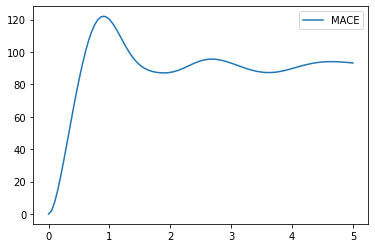

In [1269]:
plt.plot(tspan,real(Tot_excit),label="MACE")
#plt.plot(tspan,Texc,label="CMF")
#plt.plot(tspan,real(Tot_excit1),label="MACE")

plt.legend()

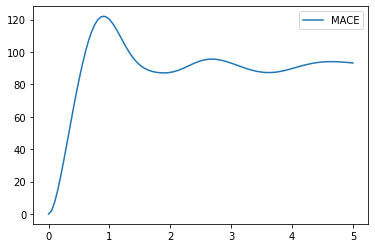

In [1270]:
plt.plot(tspan,real(Tot_excit),label="MACE")
#plt.plot(tspan,Texc,label="CMF")
#plt.plot(tspan,real(Tot_excit1),label="MACE")

plt.legend()

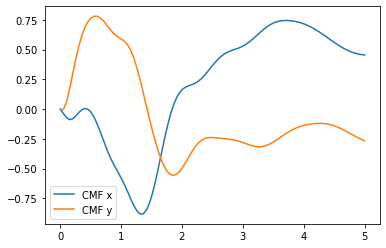

In [1271]:
plt.plot(tspan,real(Tot_minus),label="CMF x")
plt.plot(tspan,imag(Tot_minus),label="CMF y")

#plt.plot(tspan,Tx,"--",label="CMF x")
#plt.plot(tspan,Ty,"--",label="CMF y")

plt.legend()

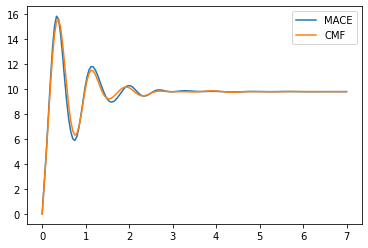

In [972]:
plt.plot(tspan,real(Tot_excit),label="MACE")
plt.plot(tspan,Texc,label="CMF")
#plt.plot(tspan,real(Tot_excit1),label="MACE")

plt.legend()

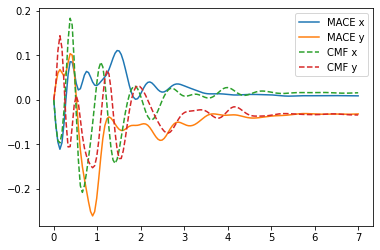

In [974]:
plt.plot(tspan,real(Tot_minus),label="MACE x")
plt.plot(tspan,imag(Tot_minus),label="MACE y")

plt.plot(tspan,Tx,"--",label="CMF x")
plt.plot(tspan,Ty,"--",label="CMF y")

plt.legend()

In [952]:
here

NameError: name 'here' is not defined

In [933]:

Rho_t= sparse.lil_matrix((4**Atom_cutoff, N_atom),dtype="complex64")   #saves the density matrices for a given time t
for j in range(N_atom):
    Rho_t[:,j]=Init_rho
    
    


        
tfinal=7
Lenght=150
tspan=np.linspace(0,tfinal,Lenght)    #Here the time definition is important because it will tell you how to divide the elements



Sigma_m_rev= sparse.lil_matrix((N_atom, len(tspan)),dtype="complex64")
Sigma_ee_rev= sparse.lil_matrix((N_atom, len(tspan)),dtype="complex64")



for j in range(N_atom):
    
    Sigma_m_rev[j,0] =Sigma_Min_alt.dot( Rho_t[:,j])[0,0]
    Sigma_ee_rev[j,0]=Sigma_EEalt.dot( Rho_t[:,j])[0,0]
    
    

In [934]:
for j in range(N_atom):
    
    Sigma_m_rev[j,0] =Sigma_Min_alt.dot( Rho_t[:,j])[0,0]
    Sigma_ee_rev[j,0]=Sigma_EEalt.dot( Rho_t[:,j])[0,0]
    

In [ ]:
Rho_mt

In [ ]:
Rho_t.todense()

In [ ]:
cent_ind=0

inst_time=0

sol_cent_ind = solve_ivp(f,[tspan[inst_time],tspan[inst_time+1]],list(array((Rho_t[:,cent_ind].todense()).T,dtype="complex")[0])
                    ,args=(Part_H_L_R_LR(cent_ind,Sigma_m_rev[:,inst_time]),None), t_eval= [tspan[inst_time+1]])

In [ ]:
Rho_t[:,0]=sol_cent_ind.y

In [ ]:
Rho_t

In [ ]:
sol_cent_ind.y

In [ ]:
here

In [ ]:
#@jit
def SplusSee_center_ind(cent_ind):
    
    
    sol = solve_ivp(f, [tspan[0], tspan[-1]], list(array((Init_rho.todense()).T,dtype="complex64")[0])
                     ,args=(Part_H_L_R_LR(cent_ind),None),dense_output=True )
    
    
    Sol_dense=(sol.sol(tspan))
    Splus_i=[]
    See_i  =[]

    Y_array=Sol_dense

    for j in range((Y_array).shape[1]):
            
        #print((Y_array)[:,j].shape)

        See=Sigma_EEalt.dot((Y_array)[:,j])[0]   #See=dot(Sigma_EE.flatten(),(Y_array)[:,j])
        Seg=Sigma_EGalt.dot((Y_array)[:,j])[0]
            
        #See=dot(Sigma_EE.flatten(),(Y_array)[:,j])
        #Seg=dot(Sigma_EG.flatten(),(Y_array)[:,j])
    
    
        See_i.append(See)
        Splus_i.append(Seg)
    
    return Splus_i, See_i

In [ ]:
Array_0=SplusSee_center_ind(1000)

In [ ]:


def result_tot(Atom_cutoff):

        
    
    Sigma_eg=csr_matrix(np.array([[0,1],
                              [0,0]]),dtype="complex64")
    Id_2LS  =csr_matrix(np.array([[1,0],
                              [0,1]]),dtype="complex64")

    Zero_2LS=csr_matrix(np.array([[0,0],
                              [0,0]]),dtype="complex64")

    state   =csr_matrix(np.array([[0,0],
                              [0,1]]),dtype="complex64")


    Sigma_ee=csr_matrix(np.array([[1,0],
                              [0,0]]),dtype="complex64")

    Sigma_egT=Sigma_eg.T    

    
    
    
    #@jit

    def index_Gij(arr,Atom_cutoff):
    
        Ordered_N = list(np.argsort(arr)[::-1][:Atom_cutoff])
    
        return Ordered_N

    Index_N=[]

    Rem_iden=abs(Gij - 1j*0.5*Gamma_r*np.identity(N_atom))


    for j in range(Rem_iden.shape[0]):
    
        test_list = list(Rem_iden[j])
    
        Index_N.append( [j]+list(index_Gij(test_list,Atom_cutoff-1))  )

    #@jit
    def tensor_id(ArrayL ):
    
        Tensor_id=kron(ArrayL[0],ArrayL[1])
    
        Array_id=Atom_cutoff*[Id_2LS]    
    
        for j in range(2,len(ArrayL)):
        
            Tensor_id=kron(Tensor_id,Array_id[j])
        
    
        return coo_matrix(Tensor_id)
    
    
    
    
    

    #@jit
    def tensor_kj( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
        Array_id=Atom_cutoff*[Id_2LS]  
    
        Array_id[k]=Sigma_eg
        Array_id[j]=Sigma_egT
    
        Tensor_kj=kron(Array_id[0],Array_id[1])
    
        for j in range(2,len(Array_id)):
        
            Tensor_kj=kron(Tensor_kj,Array_id[j])
        
    
        return coo_matrix(Tensor_kj)
    
    
    

    #@jit
    def tensor_k_ee( k  ):  #Excited state k is a Position in the cluster after the G classification
    
        Array_id=Atom_cutoff*[Id_2LS]  
    
        Array_id[k]=Sigma_ee
    
        Tensor_k    =kron(Array_id[0],Array_id[1])
    
        for j in range(2,len(Array_id)):
        
            Tensor_k=kron(Tensor_k,Array_id[j])
        
    
        return coo_matrix(Tensor_k)

    #@jit
    def tensor_k( k  ):  #sigmaplus k
    
        Array_id=Atom_cutoff*[Id_2LS]  
    
        Array_id[k]=Sigma_eg
    
        Tensor_k    =kron(Array_id[0],Array_id[1])
    
        for j in range(2,len(Array_id)):
        
            Tensor_k=kron(Tensor_k,Array_id[j])
        
    
        return coo_matrix(Tensor_k)



    #@jit
    def init_rho(Atom_cutoff=Atom_cutoff,state=state):
    
        state_fact=Atom_cutoff*[state]
    
        Rho_in=kron(state_fact[0],state_fact[1])
    
        for j in range(2,Atom_cutoff):
        
            Rho_in=kron(Rho_in,state_fact[j])
        
        return coo_matrix(Rho_in)



    #@jit
    def Hamil_atom(index_center):
    
        Index_list=Index_N[index_center]
        Zero_gen=tensor_id(Atom_cutoff*[ Zero_2LS ])
        Z2=Zero_gen
    
        for k in range(Atom_cutoff):
        
            IL_k = Index_list[k]
        
            #print(IL_k)
        
            zL_k = ZL_k[IL_k]
            Ten_k= tensor_k(k)
        
            Z2   = Z2 -(Omega)*(zL_k*Ten_k  +conj(zL_k)*(Ten_k.T) )
        
        return Z2

    Sigma_EGalt=(tensor_k(0)).reshape(1,4**Atom_cutoff)
    Sigma_EEalt=(tensor_k_ee(0)).reshape(1,4**Atom_cutoff)
    
    #@jit

    def Part_H_L_R_LR(index_center):
    
        Array_id=Atom_cutoff*[Id_2LS] 
        Index_list=Index_N[index_center]
        Zero_gen=tensor_id(Atom_cutoff*[ Zero_2LS ])
    
        Z1=Zero_gen
        Z2=Zero_gen
        Z3=kron(Zero_gen,Zero_gen)
    
    
        Col_Decay=kron(Zero_gen,Zero_gen)
    
        Identity=tensor_id( Atom_cutoff*[Id_2LS])
    
    
        Col=Collect
    
        D_R = Zero_gen
        D_L = Zero_gen
        D_RL= kron(Zero_gen,Zero_gen)

        Hamil=Zero_gen
    
    
        Splus=Zero_gen
    
    
    
        Hamil_at=Hamil_atom(index_center)    
        Hamil_vect= -1j *(kron(Identity,  Hamil_at )-kron(Hamil_at.T,Identity))
    
    
    
    
    
        for k in range(Atom_cutoff):
        
            IL_k = Index_list[k]

            zL_k = ZL_k[IL_k]

            Ten_k= tensor_k(k)
        
            Ten_k_ee=tensor_k_ee(k)
        
        
            Splus=Splus+Ten_k
        
            Imkk=ImG[k,k]  
        
        
            #Z2   = Z2+ 1j*(Omega)*(zL_k*Ten_k  +conj(zL_k)*(Ten_k.T) )
        
        
            D_R   = D_R  - ( Imkk       )*Ten_k_ee
            D_L   = D_L  - ( Imkk       )*Ten_k_ee
            D_RL  = D_RL + ( 2 * Imkk    )*kron( Ten_k.T , Ten_k.T  )


        
        
            for j in range(k+1,Atom_cutoff):
            
                IL_j  =Index_list[j]

                Ten_kj= tensor_kj( k , j )
            
                ReGkj=ReG[IL_k,IL_j] 
                ImGkj=ImG[IL_k,IL_j]
                ReGjk=ReGkj   
                ImGjk=ImGkj
            
            
                Z1=Z1+ (1j*ReGkj-ImGkj)*(Ten_kj+ Ten_kj.T  )
            
                Ten_j=tensor_k(j)
            
            
                Tenk_Tenj=kron(Ten_k.T,Ten_j.T)

                Tenj_Tenk=kron(Ten_j.T,Ten_k.T)
            
            
                Z3=Z3+2*( ImGkj*Tenk_Tenj   +  ImGjk* Tenj_Tenk )

            #print( tensor_kj( k , j ).todense(), ReG[IL_k,IL_j],(IL_k,IL_j)  )
            
            #print(k,j)



                Hamil=Hamil+(1j*ReGkj)*(Ten_kj+ Ten_kj.T)

        Hamil=Hamil+Hamil_at                 
        
        L_R = Z2+Z1
        L_L =-(Z2.T)+conj(Z1.T) 
        L_RL=Z3
    

    #print(L_R.shape, L_L.shape, L_RL.shape)
    
        Vectorization=  ( kron(Identity,  L_R+D_R )+kron(L_L+D_L,Identity )+L_RL+D_RL ) #   + Col * Col_Decay  )

    
        return  Vectorization+Hamil_vect  #, Hamil #cl_sparse(Vectorization) #clean_sparse(Vectorization)


    Ivec=[4**Atom_cutoff-1]

    Jvec=[0]
    Vvec=[1]


    Init_rho=(sparse.coo_matrix((Vvec,(Ivec,Jvec)),shape=(4**Atom_cutoff,1))) 


    #@jit
    def f(t, yR,M_vect,b):
 
        MatA=M_vect@yR
        return MatA

    #@jit
    def SplusSee_center_ind(cent_ind):
    
    
        sol = solve_ivp(f, [tspan[0], tspan[-1]], list(array((Init_rho.todense()).T,dtype="complex64")[0])
                     ,args=(Part_H_L_R_LR(cent_ind),None),dense_output=True )
    
    
        Sol_dense=(sol.sol(tspan))
        Splus_i=[]
        See_i  =[]

        Y_array=Sol_dense

        for j in range((Y_array).shape[1]):
            
            

            See=Sigma_EEalt.dot((Y_array)[:,j])[0]   #See=dot(Sigma_EE.flatten(),(Y_array)[:,j])
            Seg=Sigma_EGalt.dot((Y_array)[:,j])[0]
            
            #See=dot(Sigma_EE.flatten(),(Y_array)[:,j])
            #Seg=dot(Sigma_EG.flatten(),(Y_array)[:,j])
    
    
            See_i.append(See)
    
            Splus_i.append(Seg)
    
        return Splus_i, See_i



    Array_0=SplusSee_center_ind(0)

    Splus=array(Array_0[0])
    See_r=array(Array_0[1])

    for j in range(1,N_atom):
    
        Array_j=SplusSee_center_ind(j)
    
        Splus_j=array(Array_j[0])
        See_r_j=array(Array_j[1])
    
        #plt.plot(tspan, real(See_r_j),"->")
        #plt.plot(tspan, real(Splus_j))
    #plt.plot(tspan, imag(Splus_j),"->")
    
    
    
        Splus=Splus+Splus_j
        See_r=See_r+See_r_j
    
        print(j)

  
    return See_r, Splus


Cluster_s=2

Result=result_tot(Cluster_s)
See_r_=Result[0]
Splus_=Result[1]



# Displaying the array


file = open("Results"+str(Cluster_s)+"_Omega_"+str(Omega)+"_Lax="+str(Sigma_x)+".txt", "w+")

# Saving the array in a text file

char1=str(N_atom)
char2=str(Cluster_s)
char3=str(Omega)
file.write(char1)
file.write('\n')

file.write(char2)
file.write('\n')

file.write(char3)
file.write('\n')

file.write('\n')

content2 = str(See_r_)
file.write(content2)
file.write('\n')
file.write('\n')
content12= str(Splus_)
file.write(content12)
file.write('\n')
file.write('\n')

file.close()

## Displaying the contents of the text file
#file = open("Array_MACE.txt", "r")
#content = file.read()

#print("Array contents in sample.txt: ", content)
#file.close()

t1=time.time()
